<a href="https://www.kaggle.com/code/wkaisertexas/international-science-fair-analysis?scriptVersionId=130466941" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# International Science Fair (ISEF) Analysis
**Several years ago**, I scraped a dataset of all of the projects and abstracts from the international science fair. While I really wanted someone to do a "meta" science fair project analyzing science fair projects, I could not convince anyone to do that. So, in this notebook, I am going to attempt to do it myself. 

Analysis will take place in **4 steps:**
- Project growth over time
- Category growth over time
- Awards growth over time
- t-SNE visualization of categories using ~~BERT~~ OpenAI's `ada_embeddings`
- K-means to figure out which projects have the greastest distance from their category (ie. category fraudsters)

A bit of context is required for that last point. In some science fair circles, it is suggested that you move into categories adjanct to your project. Then, your project stands out more from your competition. While this is technically category fraud, it is rarely enforced except in the most extreme of cases because it is easy to make a weak argument for why your project belongs in the adjacent category.

In [1]:
import os

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import tensorflow_hub as hub
from matplotlib import pyplot as plt
import matplotlib as mpl

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from matplotlib.ticker import PercentFormatter as PercentFormatter

from tqdm import tqdm
tqdm.pandas()

from IPython.display import Image

# size
mpl.rcParams['figure.figsize'] = (14, 8)

# color scheme
custom_colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'cyan',
                 'magenta', 'olive', 'teal', 'navy', 'gold', 'indigo', 'lime', 'maroon', 'orchid', 'turquoise',
                 'salmon', 'sienna', 'slateblue', 'tomato', 'seagreen']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)

# Getting to Know the Data a Bit More

What exactly did I scrape? The dataset has the following information:
- `tiles`
- `category`
- `year`
- `school`
- `abstract`
- `id`
- `state`
- `Province`
- `awards`


In [2]:
# getting all ISEF abstracts
ds = pd.read_csv('../input/all-international-science-fair-projects/isef-database.csv')
ds.dropna(subset=['abstract', 'title'])

ds.sample(5)

# I deeply regret naming it `ds` instead of `df` but it is too late now

,title,category,year,schools,abstract,id,country,State,Province,awards
4323,A Wearable Electronic Anti-smog Face Mask\r\n,Materials Science,2017,"{'Redlands East Valley High School', 'Universi...",NaN,ProjectId=5166,NaN,NaN,NaN,NaN
10020,The Feasibility of the Extraction of (2E)-3-ph...,Chemistry,2021,{'Canyon del Oro High School'},The inner bark of the Chinese cinnamon tree Ci...,ProjectId=20755,United States of America,AZ,NaN,['nan']
4107,dQCuts: Simplifying Analysis of Large Molecula...,NaN,2016,set(),Analysis of protein chains has shifted into a ...,ProjectId=11805,United States of America,TN,NaN,['nan']
4581,Water Surface Vibration Signals Utilized by th...,Animal Sciences,2017,"{'Homeschool', 'Northside Health Careers High ...",NaN,ProjectId=5444,Japan,NaN,NaN,['Acoustical Society of America: Honorable Men...
10983,"BoxProtect: Identification of 2-Methoxy-1,4-Na...",Biochemistry,2022,{'Nellenburg Gymnasium'},Himalayan Balsam (Impatiens glandulifera R.) i...,ProjectId=21798,Germany,NaN,Hamburg,['Fourth Award of $500']


In [3]:
# Converting `id` into an integer
ds['id'] = ds['id'].apply(lambda x: int(str(x).split("=")[-1]))
ds['id']

0        13244
1        13245
2        13246
3        13247
4        13248
         ...  
12266    23168
12267    23169
12268    23170
12269    23171
12270    23172
Name: id, Length: 12271, dtype: int64

In [4]:
# Getting `place` awards
place_awards = [
    "First Award of $5,000",
    "Second Award of $2,000",
    "Third Award of $1,000",
    "Fourth Award of $500",
]

def get_place(x):
    """
    Gets the place of the awards (1st, 2nd, 3rd, 4th)
    """
    if isinstance(x, str):
        # need to try and eval 
        try:
            x = eval(x)
        except:
            return -1 # not found / cound not parse

    if not hasattr(x, "__iter__"):
        return -1

    for award in x:
        try:
            index = place_awards.index(award) + 1 # indexes start at zero
            return index
        except ValueError:
            continue # not found
            
    return -1 # -1 equals not found

ds['place'] = ds['awards'].apply(get_place)
print(f"{100 * ds['place'].apply(lambda x: x > 0).mean():.2f} % of projects placed")

19.19 % of projects placed


# Exploratory Data Analysis of ISEF Projects

Providing insights about structural changes in competition before further anaylsis. This data will be then used to provide a baseline about ISEF and the projects and categories contained with the compiled dataset. 

In addition, trends surrouding project and award growth and keywords will be analyzed.

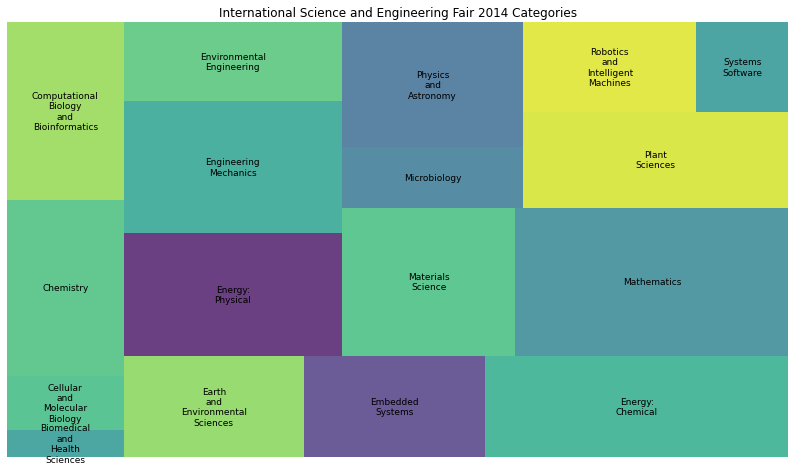

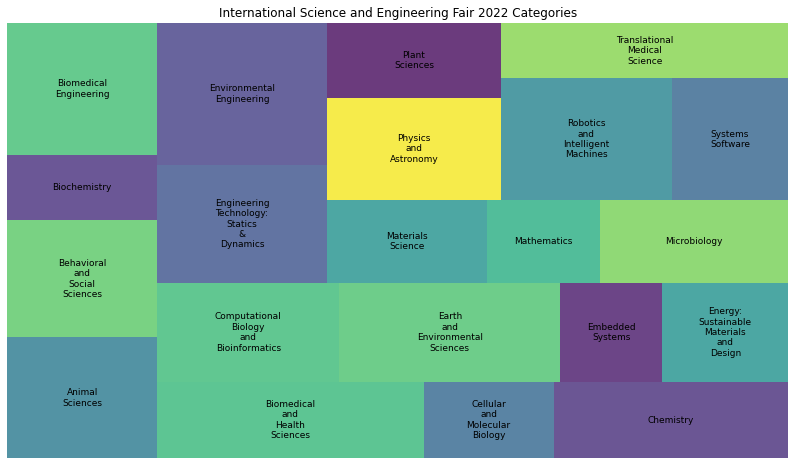

In [5]:
# Old Categories
import squarify

category_counts = ds[ds['year'] == 2014].groupby('category')['title'].count()
index = list(map(lambda x: x.replace(" ", "\n"), category_counts.index))
squarify.plot(sizes=category_counts.values, label=index, alpha=.8, text_kwargs={'fontsize':9})
plt.axis('off')
plt.title("International Science and Engineering Fair 2014 Categories")
plt.savefig("category_propotionality_2014.png", transparent=False)
plt.show()

# New Categories
category_counts = ds[ds['year'] == ds['year'].max()].groupby('category')['title'].count()
index = list(map(lambda x: x.replace(" ", "\n"), category_counts.index))
squarify.plot(sizes=category_counts.values, label=index, alpha=.8, text_kwargs={'fontsize':9})
plt.axis('off')
plt.title(f"International Science and Engineering Fair {ds['year'].max()} Categories")
plt.savefig("category_propotionality.png", transparent=False)
plt.show()

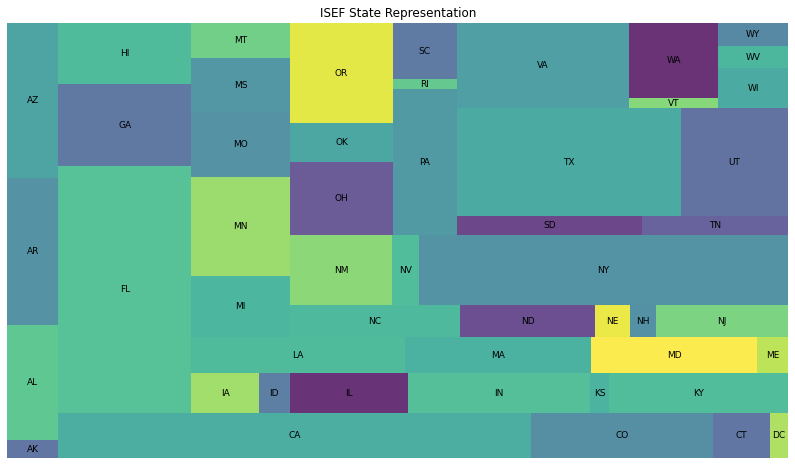

(1.5418502202643172, 1.3592233009708738, 1.2612612612612613, 2.229299363057325)

In [6]:
import squarify

states = ds.groupby('State')['title'].count()
squarify.plot(sizes=states.values, label=states.index, alpha=.8, text_kwargs={'fontsize':9})
plt.axis('off')
plt.title("ISEF State Representation")
plt.savefig("state_representation.png")
plt.show()
states['FL'] / states['CA'], states['FL'] / states['TX'], states['FL'] / states['NY'], states['FL'] / states['VA']

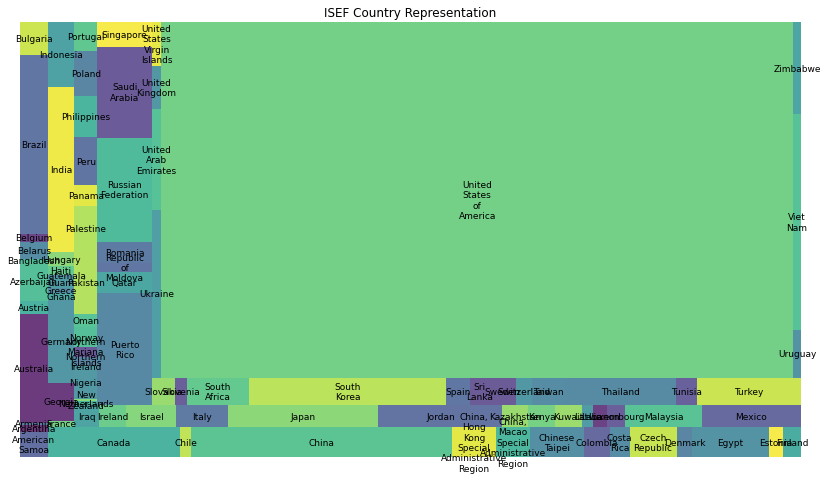

In [7]:
# Country Representation
country = ds.groupby('country')['title'].count()

index = list(map(lambda x: x.replace(" ", "\n"), country.index))
squarify.plot(sizes=country.values, label=index, alpha=.8, text_kwargs={'fontsize':9})
plt.axis('off')
plt.title("ISEF Country Representation")
plt.savefig("country_representation.png")
plt.show()

In [8]:
# These plots should be smaller
mpl.rcParams['figure.figsize'] = (10, 7)

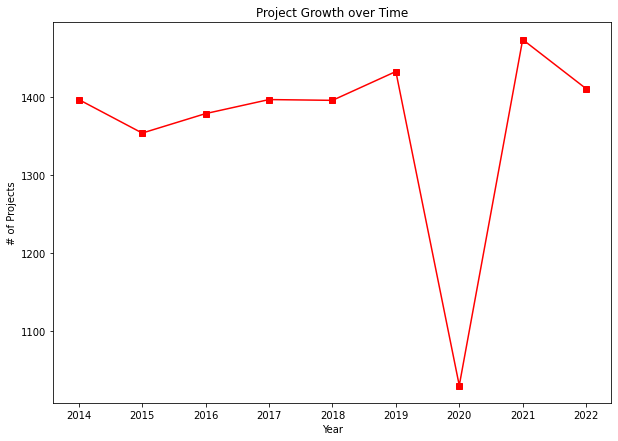

In [9]:
# plots project growth over time
projects = ds.groupby('year').count()
plt.plot(projects['title'], marker='s') # all projects have a title
plt.xlabel('Year')
plt.ylabel('# of Projects')
plt.title('Project Growth over Time')

plt.savefig('project_growth_over_time.png')
plt.show()

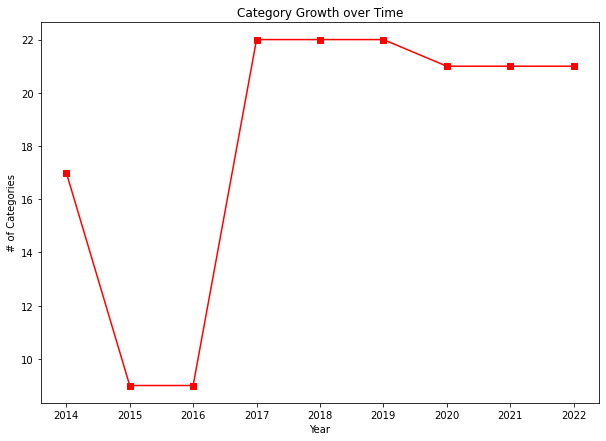

In [10]:
# generate a plot of categories versus awards over time
categories = ds.groupby('year').nunique() # Why is this a function?
plt.plot(categories['category'], marker='s')
plt.xlabel('Year')
plt.ylabel('# of Categories')
plt.title('Category Growth over Time')
plt.savefig('category_growth_over_time.png')
plt.show()

# NOTE: Category data seems to be missing from the website for projects from 2015 to 2016

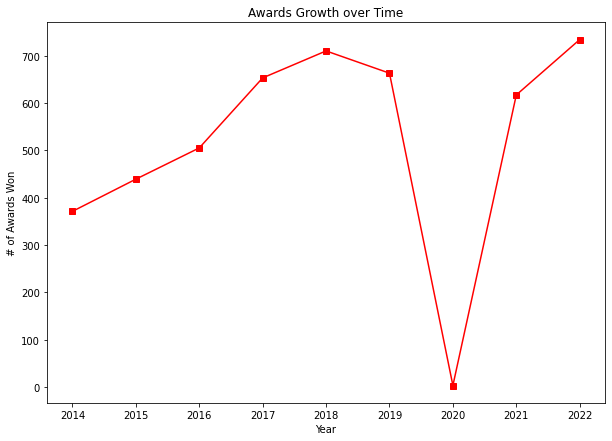

In [11]:
# award growth over time
def get_awards(elem): # I could use regex to get a dollar amount ig?
    """
    Computes the number of awards a project received
    
    Overcomplicated function as I 
    """
    if type(elem) is float:
        return 0 # nan, but just not in a list
    
    if type(elem) is str:
        elem = eval(elem)
        
    if not elem: # some have a nonetype
        return 0
        
    return len([i for i in elem if i != "nan"])
               
ds['num_awards'] = ds['awards'].apply(get_awards)
awards = ds.groupby('year').sum()
plt.plot(awards['num_awards'], marker='s')
plt.xlabel('Year')
plt.ylabel('# of Awards Won')
plt.title('Awards Growth over Time')
plt.savefig('award_growth_over_time.png')
plt.show() # note: suprised there was not more award inflation

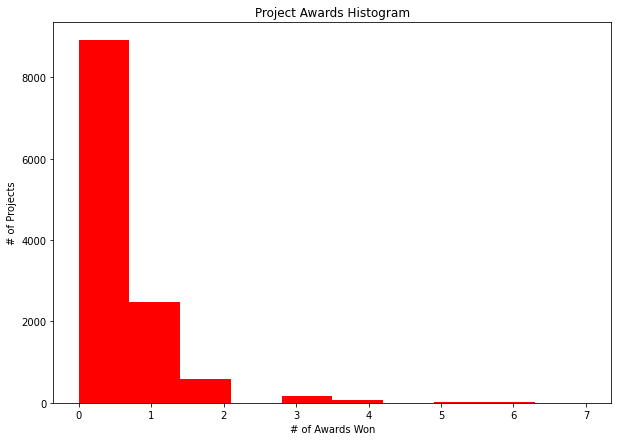

In [12]:
# Normal Awards Distribution Histogram
plt.hist(ds['num_awards'])

plt.title('Project Awards Histogram')
plt.xlabel('# of Awards Won')
plt.ylabel('# of Projects')

plt.savefig('num_awards_distribution.png')
plt.show()

In [13]:
print(f"Average number of awards won: {ds['num_awards'].mean(): .2f}")
print(f"Projects winning awards: {ds['num_awards'].apply(lambda x: x > 0).mean() * 100: .1f}%")

Average number of awards won:  0.38
Projects winning awards:  27.4%


# Best Projects (Creme de la creme)

Given the **difficulty** of winning awards at ISEF, let's pick out a few sample projects to see what constitutes a top-tier science fair projects. Reading through some of these project titles and abstracts should give a greater sense about **judges preferences for projects**.

In [14]:
awards_cutoff = 6
top_tier_projects = ds[ds['num_awards'] >= awards_cutoff]
print(f"{top_tier_projects.shape[0]} projects have more than {awards_cutoff} awards")
print(f"This represents the top {top_tier_projects.shape[0] / ds.shape[0] * 100:0.1f} % of projects")

19 projects have more than 6 awards
This represents the top 0.2 % of projects


In [15]:
print("Top Project Titles:\n")
_ = top_tier_projects.sample(5)['title'].apply(print)

Top Project Titles:

Utilizing Computer Vision and Machine Learning Systems to Develop a Live Time Navigational and Surgical Aid for Spinal Reconstructions
LaserWAN - Laser Broadband Internet Connections
Around the World in Eighty Days: Small Radiosondes on a Great Mission
Drone Defense System: Detection, Tracking, Classification and Targeting of Flight Objects in 3D and Real Time
Generating Energy From Wheel Motion by Designing a Hybrid 3D-Printed Triboelectric Nanogenerator


In [16]:
_ = top_tier_projects.sample(2).apply(lambda x: print("Title:  " + str(x['title']) + "\n\n" + str(x['abstract']) + "\n--------------\n"), axis=1)

Title:  An Investigation into the Removal of Microplastics from Water Using Ferrofluids

This project investigates a new method for the extraction of microplastics (plastic particles less than 5mm in diameter) from water. Currently, no screening or filtering for microplastics takes place in any European wastewater treatment centres.
This method was inspired by an article by Dr Arden Warner, who used non-toxic iron oxide (magnetite) to clean up oil-spills. I used this method to extract microplastics from water, by adding oil to a suspension containing a known concentration of microplastics. After these migrated into the oil phase, magnetite powder was added. The resulting microplastic-containing ferro-fluid was removed using strong magnets.
The hypothesis was that this extraction method would remove 85% or higher of microplastics in samples.
To measure the concentration of microplastics in a given sample, I built a visible light spectrometer which analysed the spectra of light passed th

# Abstract Trends

Because both **abstract** and **titles** will be used, learning something about the underlying data will help guide further analysis.

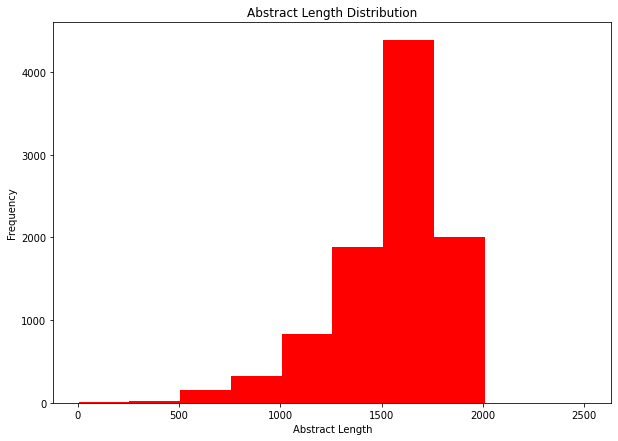

In [17]:
# abstract length histogram
abs_length = ds['abstract'].apply(lambda x: len(str(x))) 
plt.hist(ds[abs_length > 3]['abstract'].apply(lambda x: len(str(x))))
plt.xlabel('Abstract Length')
plt.ylabel('Frequency')
plt.title('Abstract Length Distribution')
plt.savefig('abstract_length.png')
plt.show()

## Novelty Bias

A general trend among science fair projects has been to discuss novel solutions in projects. While a fixation on novelty is not necessarily good for more established research, the increased bias towards novelty seems to be reflective of a less streneous process compared to research affiliated with academic institutions.

However, some claim that novelty provides a tangeable benefit for competition performance, a claim which will be investigated.

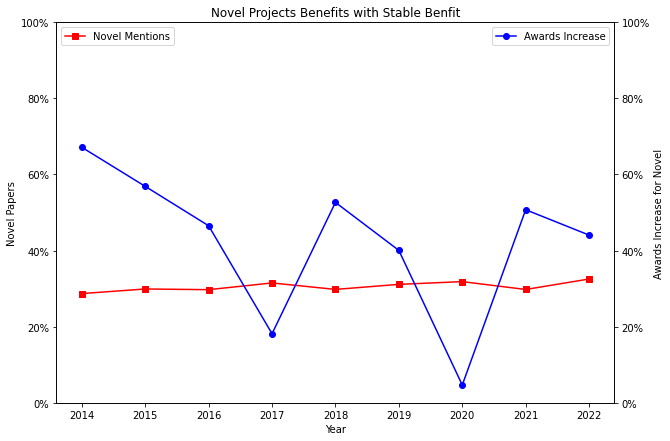

In [18]:
def novel(x):
    """
    Filter for projects with 'new' or 'novel' in the title or abstract
    """
    project_text = str(x['abstract']).lower() + str(x['title']).lower()
    return 'new' in project_text or 'novel' in project_text

ds['novel'] = ds.apply(novel, axis=1)
novel = ds.groupby('year')['novel'].mean()

fig, ax = plt.subplots()

ax.plot(novel, marker='s', label="Novel Mentions")

ax.set_xlabel('Year')
ax.set_ylabel('Novel Papers')


novel_awards = ds[ds['novel']].groupby('year')['num_awards'].mean()
novel_awards_boost = (novel_awards / ds.groupby('year')['num_awards'].mean() - 1)

ax1 = ax.twinx()

ax1.set_ylabel('Awards Increase for Novel')
ax1.plot(novel_awards_boost, marker='o', label="Awards Increase", color="blue")

ax.set_ylim(bottom=0, top=1)
ax1.set_ylim(bottom=0, top=1)

ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
ax1.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))

ax.legend(loc='upper left')
ax1.legend(loc='upper right')

ax.set_title('Novel Projects Benefits with Stable Benfit')
fig.savefig('novelty_bias.png', transparent=False)
fig.show()

In [19]:
novelty_and_awards = ds.groupby('novel')['num_awards'].mean()
print(f"Non-novel projects win on average: {novelty_and_awards[0]:.2f}")
print(f"Novel projects win on average: {novelty_and_awards[1]:.2f}")
print(f"Novel provides a statistical benefit of: {(novelty_and_awards[1] / novelty_and_awards[0] - 1) * 100:.1f} %")

Non-novel projects win on average: 0.31
Novel projects win on average: 0.56
Novel provides a statistical benefit of: 81.3 %


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == "":


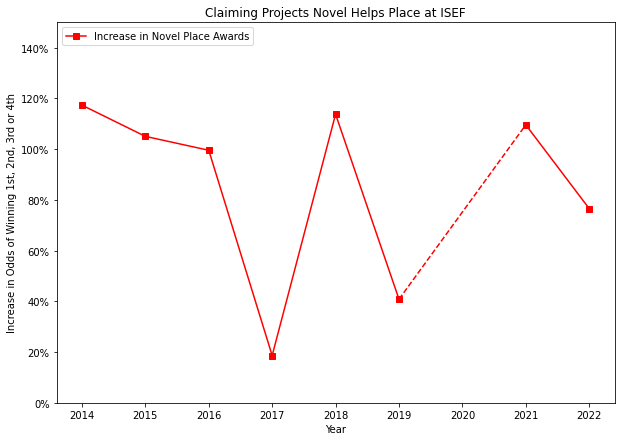

In [20]:
def novel_bias(x):
    """
    Novel bias will calculate the percentage of place awards for 
    both novel and non-novel projects and return the benefit
    """
    novel_projects = x[x['novel']]
    non_novel_projects = x[x['novel'] != True]
    
    novel_place_percentage = novel_projects['place'].apply(lambda x: x > 0).mean() # mean returns a fraction with place awards (easier than doing the calculation manually)
    non_novel_place_percentage = non_novel_projects['place'].apply(lambda x: x > 0).mean() # mean returns a fraction with place awards (easier than doing the calculation manually)
    
    return (novel_place_percentage / non_novel_place_percentage - 1)

percent_increase_in_place_awards = ds.groupby('year').apply(novel_bias)

fig, ax = plt.subplots()

ax.plot(percent_increase_in_place_awards, label="Increase in Novel Place Awards", marker="s")

plt.plot([2019, 2021], [percent_increase_in_place_awards.loc[2019], percent_increase_in_place_awards.loc[2021]], color="red", linestyle='--')

ax.set_xlabel('Year')
ax.set_ylabel('Increase in Odds of Winning 1st, 2nd, 3rd or 4th')

ax.set_ylim(bottom=0, top=1.5)
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))

ax.legend(loc='upper left')

ax.set_title('Claiming Projects Novel Helps Place at ISEF')
fig.savefig('novelty_bias_place_awards.png', transparent=False)
fig.show()

## Machine Learning

Machine learning and AI have entered the zeitgeist in a major way recently. However, a move towards machine learning has been taking place for some time in ISEF. 

Maximum increase in number of awards won 276.55%
Minimum number of projects 0.93%
Maximum number of projects 8.15%


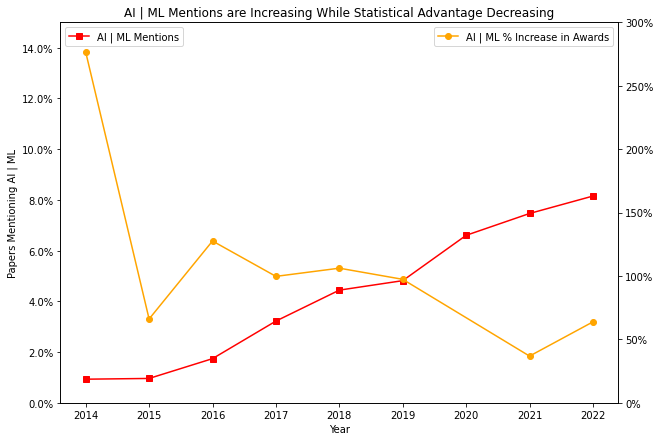

In [21]:
# Machine Learning Growth
def machine_learning(x):
    project_text = str(x['abstract']).lower() + str(x['title']).lower()
    return 'machine learning' in project_text or 'artifical intelligence' in project_text

ds['machine_learning'] = ds.apply(machine_learning, axis=1)
machine_learning = ds.groupby('year')['machine_learning'].mean()
machine_learning_awards = ds[ds['machine_learning']].groupby('year')['num_awards'].mean()
machine_learning_boost = (machine_learning_awards / ds.groupby('year')['num_awards'].mean() - 1)
machine_learning_boost = machine_learning_boost[machine_learning_boost.index != 2020]

fig, ax = plt.subplots()

ax.plot(machine_learning, marker='s', label="AI | ML Mentions")

ax.set_xlabel('Year')
ax.set_ylabel('Papers Mentioning AI | ML')
ax1.set_ylabel('% Awards Increase for ML')

ax1 = ax.twinx()

ax1.plot(machine_learning_boost, marker='o', label="AI | ML % Increase in Awards", color="orange")

ax.legend(loc="upper left")
ax1.legend()

ax.set_ylim(0, .15)
ax1.set_ylim(0, 3)

ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
ax1.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))

ax.set_title('AI | ML Mentions are Increasing While Statistical Advantage Decreasing')
fig.savefig('machine_learning_growth.png')
fig.show()

print(f"Maximum increase in number of awards won {machine_learning_boost.max() * 100:.2f}%")
print(f"Minimum number of projects {machine_learning.min() * 100:.2f}%")
print(f"Maximum number of projects {machine_learning.max() * 100:.2f}%")

In [22]:
ml_and_awards = ds.groupby('machine_learning')['num_awards'].mean()
print(f"Non-ML projects win on average: {ml_and_awards[0]:.2f}")
print(f"Machine Learning projects win on average: {ml_and_awards[1]:.2f}")
print(f"Machine Learning provides a statistical benefit of: {(ml_and_awards[1] / ml_and_awards[0] - 1) * 100:.1f} %")

Non-ML projects win on average: 0.37
Machine Learning projects win on average: 0.71
Machine Learning provides a statistical benefit of: 94.3 %


In [23]:
# Novel + ML CASE
both_novel_and_ml = ds[ds['machine_learning'] & ds['novel']]

print(f"There are {both_novel_and_ml.shape[0]} mentioning both ML and Novel")
print(f"These projects win on average {both_novel_and_ml['num_awards'].mean():.2f} awards")
print(f"This represents an advantage of {(both_novel_and_ml['num_awards'].mean() / ds['num_awards'].mean() - 1) * 100:.2f} %")

There are 232 mentioning both ML and Novel
These projects win on average 0.79 awards
This represents an advantage of 107.29 %


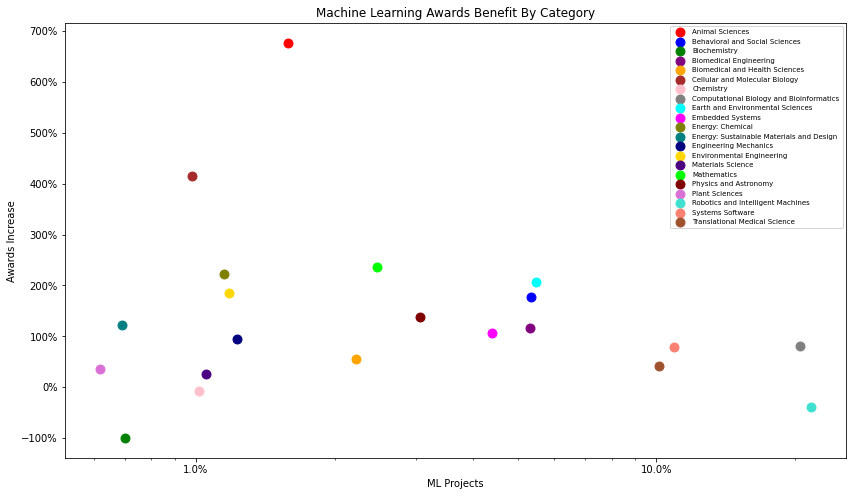

In [24]:
# size
mpl.rcParams['figure.figsize'] = (14, 8)

# machine learning and categoires
def ml_density(x):
    """
    Calculates the density of ML projects per category
    """
    return x['machine_learning'].mean() 

def ml_benefit(x):
    """
    Compares the number of awards won by ML and non-ml projects
    """
    ml = x[x['machine_learning']]['num_awards'].mean()
    normal = x[x['machine_learning'] == False]['num_awards'].mean()
    
    return (ml / normal - 1)

density = ds.groupby('category').apply(ml_density)
benefit = ds.groupby('category').apply(ml_benefit)

plot, ax = plt.subplots()

for i, density in enumerate(density):
    if density < 0.005: # removes 1 microbiology project which messes teh plot up
        continue # NO ML Projects

    ax.scatter(density, benefit.values[i], s=80, label=benefit.index[i])

plt.legend(fontsize=7)

plt.title("Machine Learning Awards Benefit By Category")
plt.xlabel("ML Projects")
plt.ylabel("Awards Increase")

plt.xscale('log')

plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1.0))

plt.savefig("ml_benefit_by_category.png", transparent=False)
plt.show()

# Curing cancer

"You have to cure cancer to win ISEF" has been a longstanding joke in the ISEF community. 

- Does this claim have merit?
- Do projects with mention of cancer perform **win more awards**?


> This section was added after completing [LDA](#)

In [25]:
# These plots should be smaller
mpl.rcParams['figure.figsize'] = (10, 7)

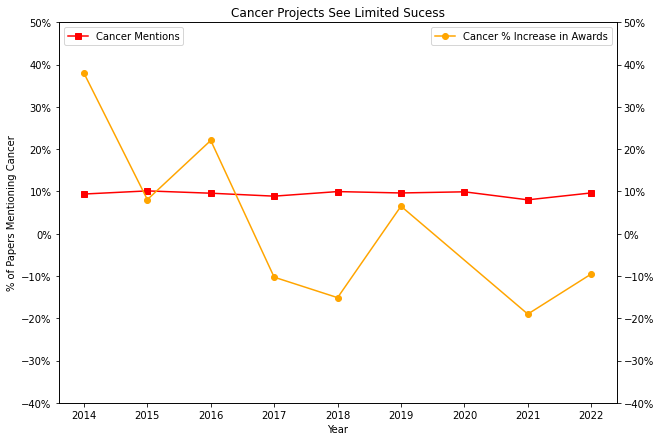

In [26]:
# Cancer Growth
def cancer(x):
    project_text = str(x['abstract']).lower() + str(x['title']).lower()
    return 'cancer' in project_text or 'tumor' in project_text

ds['cancer'] = ds.apply(cancer, axis=1)
cancer = ds.groupby('year')['cancer'].mean()
cancer_awards = ds[ds['cancer']].groupby('year')['num_awards'].mean()
cancer_boost = (cancer_awards / ds.groupby('year')['num_awards'].mean() - 1)
cancer_boost = cancer_boost[cancer_boost.index != 2020]

fig, ax = plt.subplots()

ax.plot(cancer, marker='s', label="Cancer Mentions")

ax.set_xlabel('Year')
ax.set_ylabel('% of Papers Mentioning Cancer')
ax1.set_ylabel('% Awards Increase for Cancer')

ax1 = ax.twinx()

ax1.plot(cancer_boost, marker='o', label="Cancer % Increase in Awards", color="orange")

ax.legend(loc="upper left")
ax1.legend()

ax.set_ylim(-0.4, 0.5)
ax1.set_ylim(-0.4, 0.5)

ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
ax1.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))

ax.set_title('Cancer Projects See Limited Sucess')
fig.savefig('cancer_growth.png')
fig.show()

# Two-Pronged Titles

A common tactic for writing titles has been the format `cheecky title: serious title`. Using this tactic is seen as a **low-risk way for students to add personality** to their work while remaining professional. Often, the `cheecky title` is merely a non-technical project title.

> **Note:** this section was recommended by the global **9th place ISEF finalist in 2023** and is considered by many in the science fair community to be a scourge. 

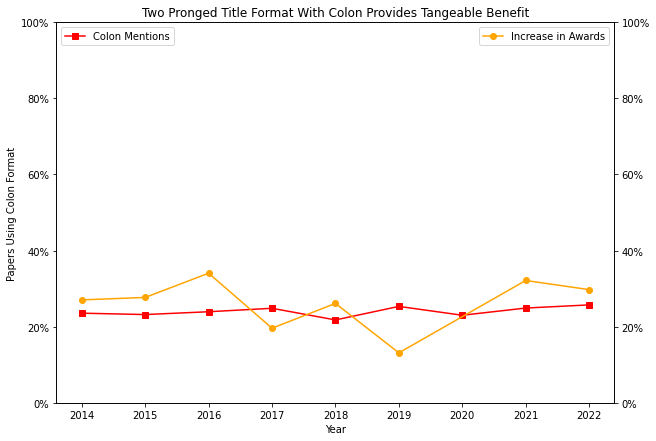

In [27]:
def two_pronged_titles(x):
    """
    Cheecky titles has a colon in their title to split their project into two seperate parts. 
    
    Manual examination of the dataset shows that not all project which follow this format 
    have a non-serious leading title. More work needs to be done to determine the "cheekyness"
    of a particular project title
    """
    project_text = str(x['title']).lower()
    return ':' in project_text

ds['cheecky_titles'] = ds.apply(two_pronged_titles, axis=1)
cheecky_titles = ds.groupby('year')['cheecky_titles'].mean()
cheecky_titles_awards = ds[ds['cheecky_titles']].groupby('year')['num_awards'].mean()
cheecky_titles_boost = (cheecky_titles_awards / ds.groupby('year')['num_awards'].mean() - 1)
cheecky_titles_boost = cheecky_titles_boost[cheecky_titles_boost.index != 2020]

fig, ax = plt.subplots()

ax.plot(cheecky_titles, marker='s', label="Colon Mentions")

ax.set_xlabel('Year')
ax.set_ylabel('Papers Using Colon Format')
ax1.set_ylabel('Awards Increase for Colon Format')

ax1 = ax.twinx()

ax1.plot(cheecky_titles_boost, marker='o', label="Increase in Awards", color="orange")

ax.legend(loc="upper left")
ax1.legend()

ax.set_ylim(0, 1)
ax1.set_ylim(0, 1)

ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
ax1.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))

ax.set_title('Two Pronged Title Format With Colon Provides Tangeable Benefit')
fig.savefig('two_pronged.png', transparent=False)
fig.show()

# Platform Project Proposals
Proposing massive platforms utilizing a given technology represents a common way to gain attention as a project.

In speaking to current and former ISEF competitors, platform proposals were considered to be a way to more broadly contextualize a project and ennumerate the impact the technology used can have.

Max increase in awards of  175.08 %
Max percent of projects  3.88 %


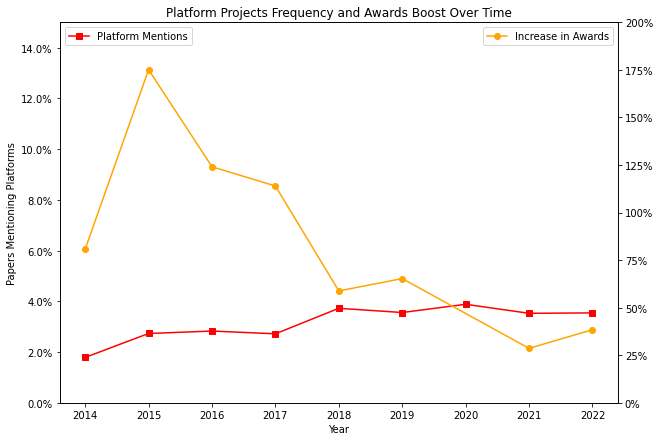

In [28]:
# Platform project proposals
def platform_project_proposals(x):
    """
    Searches for platform project proposals. 
    """
    project_text = str(x['abstract']).lower() + str(x['title']).lower()
    return 'platform' in project_text or 'mobile app' in project_text

ds['platform'] = ds.apply(platform_project_proposals, axis=1)

platform = ds.groupby('year')['platform'].mean()
platform_awards = ds[ds['platform']].groupby('year')['num_awards'].mean()
platform_boost = (platform_awards / ds.groupby('year')['num_awards'].mean() - 1)
platform_boost = platform_boost[platform_boost.index != 2020]

fig, ax = plt.subplots()

ax.plot(platform, marker='s', label="Platform Mentions")

ax.set_xlabel('Year')
ax.set_ylabel('Papers Mentioning Platforms')
ax1.set_ylabel('Awards Increase')

ax1 = ax.twinx()

ax1.plot(platform_boost, marker='o', label="Increase in Awards", color="orange")

ax.legend(loc="upper left")
ax1.legend(loc="upper right")

ax.set_ylim(0, 0.15)
ax1.set_ylim(0, 2)

ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
ax1.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))

ax.set_title('Platform Projects Frequency and Awards Boost Over Time')
fig.savefig('platform_projects.png')
fig.show()

print(f"Max increase in awards of {platform_boost.max() * 100: .2f} %")
print(f"Max percent of projects {platform.max() * 100: .2f} %")

# Preprocessing Data

`emeddings_input` is created from this step and is the `title` and the `about` with a newline for seperation. This allow papers to be clusters by both their title and abstract. 

Utilizing both `title` and `abstract` is likely to create a more **representative** embedding of a paper's content. A paper's location in the embedding space will then be used as a point of comparision between papers and clusters of papers. 

A paper's embedding is a multidimensional normal vector which, when compared with other paper's embeddings can be used to determine the similarity between papers. 

$$e_{paper} = \{e_1, e_2, e_3, ..., e_{1560} \}$$

$$| e_{paper} | = 1$$

In [29]:
def is_valid_string(x):
    """
    Checks if the `title`, `abstract` or `category` are valid
    """
    if not x:
        return None
    
    if not isinstance(x, str):
        return None
    
    if x == 'nan':
        return None
    
    return len(x) > 3

before = ds.shape[0]
mask = ds['abstract'].apply(is_valid_string)
mask &= ds['title'].apply(is_valid_string)
# mask &= ds['category'].apply(is_valid_string)

# Projects can lack a valid category and that is **okay** embeddings 
# will be used to fill this data before training

ds = ds[mask]
print(f"Lost: {before - ds.shape[0]}")
print(f"Percentage Lost: {(before - ds.shape[0]) / before * 100:.1f} %")

Lost: 2651
Percentage Lost: 21.6 %


In [30]:
# filters by valid abstracts
def prepreprocess(abstract) -> str:
    """
    Really basic preprocessing to avoid errors
    """
    abstract = str(abstract)
    return abstract.strip() # minimal

def is_valid_abstract(abstract) -> bool:
    """
    Check if there is a valid abstract
    """
    if not abstract:
        return False
    if not isinstance(abstract, str):
        return False
    
    return len(abstract) > 50

mask = ds['abstract'].apply(is_valid_abstract)
ds = ds[mask] # filters by the mask

ds['abstract'] = ds['abstract'].apply(prepreprocess) # applies preprocessing
ds['embeddings_input'] = ds.apply(lambda row: str(row['title']).strip() + '\n' + str(row['abstract']), axis=1)

total = len(mask)
num_invalid = total - mask.sum()
print(f'Invalid Data:    {num_invalid: 10d}')
print(f'Percent Invalid Abstracts: {num_invalid / total * 100:10.3f} %')

Invalid Data:             1
Percent Invalid Abstracts:      0.010 %


# OpenAI Clustering

Unlike [Textual and Impact-Based CORD19 Clustering](https://www.kaggle.com/code/williamkaiser/textual-and-impact-based-cord19-clustering), the BERT Transformer will not be used. Instead, OpenAI's GPT-3 Embeddings will serve this feature.

`text-emedding-ada-002` was used for cost-efficiency as described by OpenAI's blog post [here](https://platform.openai.com/docs/guides/embeddings/what-are-embeddings)

Data is saved to a `.parquet` so I do not **cry** when I get my **OpenAI** bill.

> **Update:** I was plesantly surprised to find runinng on ~10,000 `titles` and `abstracts` only cost \$0.29

In [31]:
%pip install openai -q

import openai

from kaggle_secrets import UserSecretsClient

# Authenticating OpenAI
user_secrets = UserSecretsClient()
openai.api_key = user_secrets.get_secret("OPENAIKEY")

Note: you may need to restart the kernel to use updated packages.


In [32]:
def get_embedding(text, model="text-embedding-ada-002"):
    text = text.replace("\n", " ").strip()
    try:
        return openai.Embedding.create(input = [text], model=model)['data'][0]['embedding']
    except:
        print("Failed to classify: ", text[:20])
        return None
            
if os.path.exists("embeddings.parquet"):
    ds = pd.read_parquet("embeddings.parquet")
elif os.path.exists("../input/isef-embeddings/embeddings.parquet"):
    ds = pd.read_parquet("../input/isef-embeddings/embeddings.parquet")
    ds['num_awards'] = ds['awards'].apply(get_awards)
else:
    ds['ada_embedding'] = ds["embeddings_input"].progress_apply(get_embedding) # this should use the title too
    ds.dropna(subset=['ada_embedding'], inplace=True)
    ds.to_parquet("embeddings.parquet")
    ds.to_csv("embeddings.csv")

ds.dropna(subset=['ada_embedding'], inplace=True)
print(f"Number of items per vector {len(ds['ada_embedding'].iloc[0])}")

Number of items per vector 1536


# t-SNE Dimensonality Reduction

Given a muti-dimensional embedding, dimensionaliy reduction takes place for data visualization.`tSNE` can not embedd the **1,536** dimension vector alone. Therefore, principle component analysis (`pca`) is used to reduce this to a manageable size before `tSNE` is applied.

In [33]:
import matplotlib.pyplot as plt
import matplotlib
from sklearn.manifold import TSNE

matrix = ds["ada_embedding"].to_list()

tsne = TSNE(
    2,
    perplexity=50,
    init="pca"
)
%time vis_dims = tsne.fit_transform(matrix)
tsne.learning_rate = 0.00000000000000000001 # freezing
ds['x'] = vis_dims[:, 0]
ds['y'] = vis_dims[:, 1]

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


CPU times: user 4min 32s, sys: 4.29 s, total: 4min 37s
Wall time: 1min 14s


In [34]:
# size
mpl.rcParams['figure.figsize'] = (14, 8)

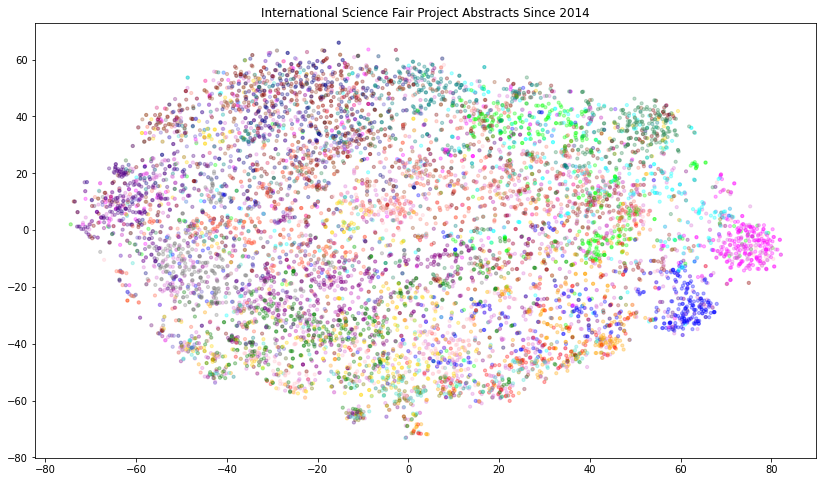

In [35]:
categories = ds['category'].unique().tolist()

def categories_to_colors(x):
    """
    Maps categories to colors
    """
    try:
        index = categories.index(x)
        
        return custom_colors[index]
    except:
        return custom_colors[0]

# Plotting tSNE Data
x = [x for x, y in vis_dims]
y = [y for x, y in vis_dims]    

category_color = ds["category"].apply(categories_to_colors).to_list()

plt.scatter(x, y, c=category_color, s=10, alpha=0.3)

plt.title("International Science Fair Project Abstracts Since 2014")
plt.savefig("base_tsne.png")
plt.show()

# k-Means Clustering

Given just the title and abstract's embeddings, clusters of similar papers will be reformed. 

If textual content is **representative of project category**, clusters should be roughly analogous to categories

In [36]:
from sklearn.decomposition import PCA

pca = PCA(15).fit(matrix)
pca_matrix = pca.transform(matrix)
# ds['pca'] = pca_matrix
len(matrix[0]), pca_matrix.shape[1], pca_matrix.shape[1] / len(matrix[0])

(1536, 15, 0.009765625)

In [37]:
from sklearn.cluster import KMeans

from sklearn import metrics
from scipy.spatial.distance import cdist

# distortions calculations for different n
distortions = []
k_clusters = [i for i in range(2, 30, 4)] + [1, 3, 4]
k_clusters = sorted(k_clusters)

for k in tqdm(k_clusters):
    k_means_model = KMeans(n_clusters=k)
    
    data = k_means_model.fit(pca_matrix)
    distortions.append(sum(np.min(cdist(pca_matrix, data.cluster_centers_, 'euclidean'), axis=1)) / len(x))

100%|██████████| 10/10 [00:22<00:00,  2.25s/it]


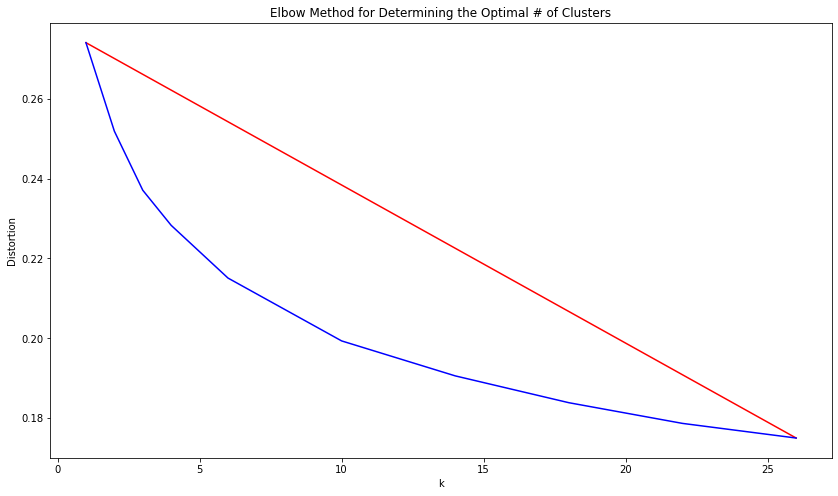

In [38]:
x_elbow = [k_clusters[0], k_clusters[-1]] # first and last k
y_elbow = [distortions[0], distortions[-1]] # first and last distortion

plt.plot(x_elbow, y_elbow, 'r')
plt.plot(k_clusters, distortions, 'b-')

plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method for Determining the Optimal # of Clusters')

plt.savefig('elbow_method_k_means.png')
plt.show()

# Final k-Mean Clustering Pass

After analysis of the elbow plot, the optimal number of clusters was selected at `n=20`. Because 20 is close to the number of categories present, th cluster was selected despite not representing a distinct bend in the elbow. 

The goal of cluster is to create a synthetic representation of a category which did not depend on the `category` column. In effect, `cluster` is the computer's best guess of which `category` is a project in. 

In [39]:
# Computing clusters
k_means_model = KMeans(n_clusters=20).fit(matrix)

ds['cluster'] = k_means_model.predict(matrix)

cluster_centers = data.cluster_centers_
tsne.learning_rate = 0.00000000001
cluster_centers_2d = tsne.fit_transform(cluster_centers)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


# Analysis of Mapping Between Cluster and Category

If `cluster`, ai-generated metric, is a good predictor of `category`, human generated, the analysis demonstrates a high-level of cohesion between cluster and category. This will be shown as cohesive colors on a segmented bar graph.

While the resultant graph is chaotic, categories tend to more dominately allocate in certain clusters. When examining this plot, clusters can range from being the modality of the group to being a miripou of different categories.

However, the plot clearly demonstrates an association between cluster and category.

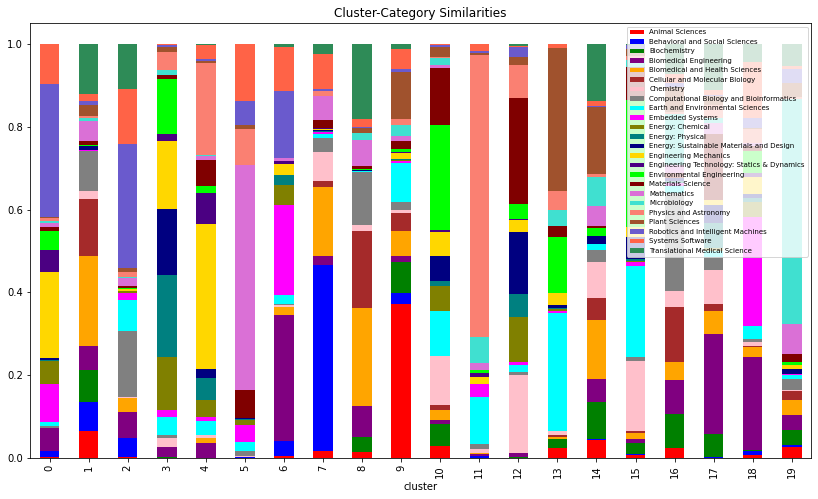

In [40]:
cross_tab = pd.crosstab(index=ds['cluster'],
                        columns=ds['category'],
                        normalize="index")
cross_tab.plot(kind='bar', 
                    stacked=True)

plt.title("Cluster-Category Similarities")
plt.legend(loc="upper right", fontsize=7)

plt.savefig("clusters_by_category.png", transparent=False)
plt.show()

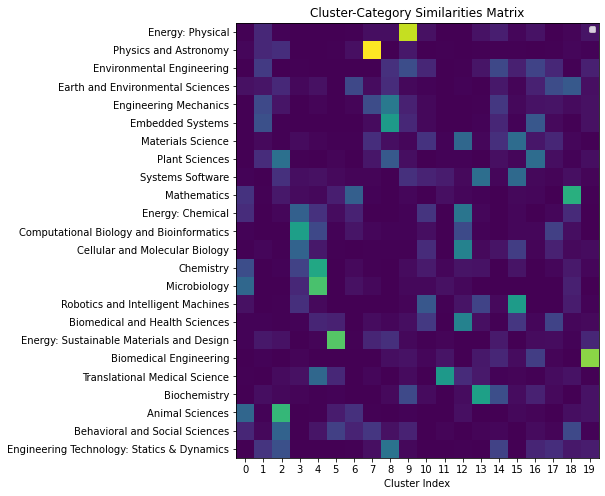

In [41]:
cross_tab = pd.crosstab(index=ds['category'],
                        columns=ds['cluster'],
                        normalize="index")
fig, ax = plt.subplots()

plt.imshow(cross_tab)

ax.set_xticks(np.arange(20), labels=[i for i in range(20)])
ax.set_yticks(np.arange(len(categories) - 1), labels=[i for i in categories if i != "" and i])

plt.title("Cluster-Category Similarities Matrix")
plt.xlabel("Cluster Index")
plt.legend(loc="upper right", fontsize=7)

plt.savefig("clusters_by_category_matrix.png", transparent=False)
plt.show()

# Category Centroid Calculation

To visualize where each cateogry is represented in 2D space, a weighted average will be taken of each paper in the category. These centroids represent project contents in there respective categories.

Plotting these centroids gives insights about the relationship and similarity between each category. 

From the plot, *Engineering: Sustainable Matrials* and *Engineering: Physical* are very close in terms of project subject matter.

Weighting cluster centers by the `num_awards` each project has one, creates a noticable, directional shift. 

In [42]:
# Unweighted
centroids_x = ds.groupby('category')['x'].mean() 
centroids_y = ds.groupby('category')['y'].mean() 

# Weighted

ds['x_weighted'] = ds['x'] * ds['num_awards']
ds['y_weighted'] = ds['y'] * ds['num_awards']
 
centroids_x_weighted = ds.groupby('category')['x_weighted'].sum() / ds.groupby('category')['num_awards'].sum()
centroids_y_weighted = ds.groupby('category')['y_weighted'].sum() / ds.groupby('category')['num_awards'].sum()

# Gets list of category
categories = centroids_x.index.tolist()
categories

['Animal Sciences',
 'Behavioral and Social Sciences',
 'Biochemistry',
 'Biomedical Engineering',
 'Biomedical and Health Sciences',
 'Cellular and Molecular Biology',
 'Chemistry',
 'Computational Biology and Bioinformatics',
 'Earth and Environmental Sciences',
 'Embedded Systems',
 'Energy: Chemical',
 'Energy: Physical',
 'Energy: Sustainable Materials and Design',
 'Engineering Mechanics',
 'Engineering Technology: Statics & Dynamics',
 'Environmental Engineering',
 'Materials Science',
 'Mathematics',
 'Microbiology',
 'Physics and Astronomy',
 'Plant Sciences',
 'Robotics and Intelligent Machines',
 'Systems Software',
 'Translational Medical Science']

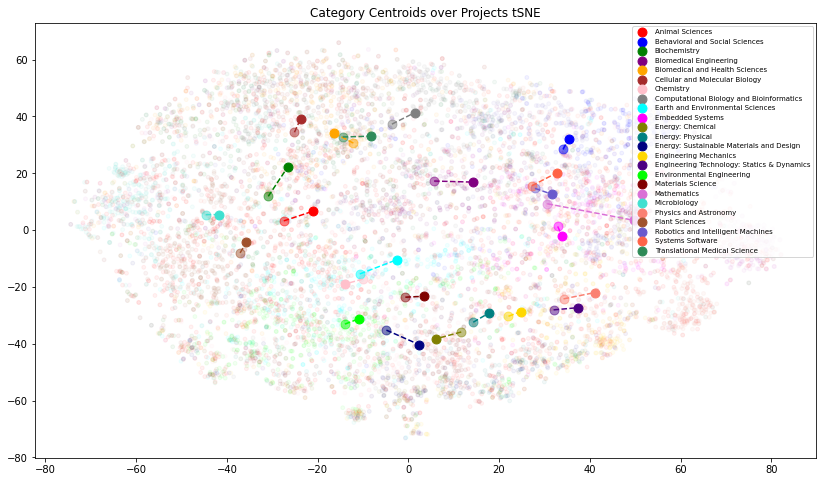

In [43]:
def categories_to_colors(x):
    """
    Maps categories to colors
    """
    try:
        index = categories.index(x)
        
        return custom_colors[index]
    except:
        return custom_colors[0]

fig, ax = plt.subplots()
  
# original plot
plt.scatter(x, y, color=ds['category'].apply(categories_to_colors), s=15, alpha=0.05)

# Create a plot with colored labels
for i, label in enumerate(categories):
    cat_color = custom_colors[i]
    ax.plot([centroids_x[i], centroids_x_weighted[i]], [centroids_y[i], centroids_y_weighted[i]], color=cat_color, linestyle="--")
    ax.scatter(centroids_x[i], centroids_y[i], color=cat_color, s=80, edgecolors=cat_color, alpha=0.5, linestyle='solid')
    ax.scatter(centroids_x_weighted[i], centroids_y_weighted[i], s=80, color=cat_color, label=label)
    
plt.title("Category Centroids over Projects tSNE")
plt.legend(loc="upper right", fontsize=7)

plt.savefig("category_centroid_movement.png", transparent=False)
plt.show()

In [44]:
import matplotlib.animation as animation

fig, ax = plt.subplots()
  
# original plot

# Create a plot with colored labels
i = 0
label=categories[0]
cat_color = custom_colors[i]

category = ds[ds['category'] == label]

scatter = ax.scatter(category['x'], category['y'], label=label, color=cat_color)

ax.set_ylim(-75, 75)
ax.set_xlim(-75, 75)

plt.title("Category Centroids over Projects tSNE")
ax.legend(loc="upper right", fontsize=9)

ax.scatter(x, y, color=ds['category'].apply(categories_to_colors), s=6, alpha=0.1)
def animate(i):
    label = categories[i]
    cat_color = custom_colors[i]
    category = ds[ds['category'] == label]

    scatter.set_offsets(np.c_[category['x'].tolist(), category['y'].tolist()])
    scatter.set_color(cat_color)
    scatter.set_label(label)
    ax.legend()

anim = animation.FuncAnimation(fig, animate, frames=len(categories), interval=3000)

category_movement_filepath = 'category_center_movement.gif'
anim.save(category_movement_filepath)

plt.close()
Image(url=category_movement_filepath)

In [45]:
import matplotlib.animation as animation

fig, ax = plt.subplots()
  
i = 0
label="Cluster " + str(i) + " ($k_{" + str(i) + "}$)"
cat_color = custom_colors[i]

category = ds[ds['cluster'] == label]
scatter = ax.scatter(category['x'], category['y'], label=label, color=cat_color)

ax.set_ylim(-75, 75)
ax.set_xlim(-75, 75)

ax.set_title("Clusters")
ax.legend(loc="upper right", fontsize=9)

ax.scatter(x, y, color=ds['cluster'].apply(categories_to_colors), s=6, alpha=0.1)

def animate(i):
    label = "Cluster " + str(i)
    cat_color = custom_colors[i]
    category = ds[ds['cluster'] == i]
    
    scatter.set_offsets(np.c_[category['x'].tolist(), category['y'].tolist()])
    scatter.set_color(cat_color)
    scatter.set_label(label)
    ax.legend()

anim = animation.FuncAnimation(fig, animate, frames=20, interval=3000)

cluster_movement_filepath = 'cluster_center_movement.gif'
anim.save(cluster_movement_filepath)

from IPython.display import Image
plt.close()
Image(url=cluster_movement_filepath)

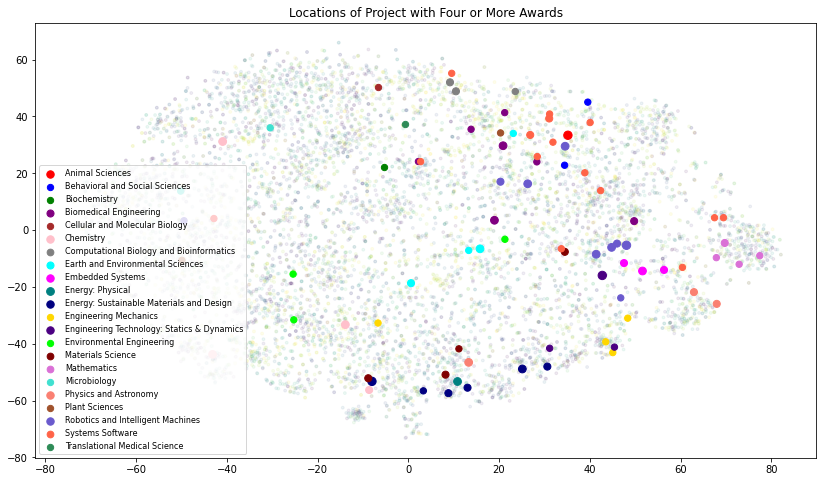

The following categories DO NOT have projects with four or more awards:


Biomedical and Health Sciences
Energy: Chemical    





In [46]:
fig, ax = plt.subplots()

top_six = ds[ds['num_awards'] >= 4]
top_six = top_six.dropna(subset=['category'])

# original plot
ax.scatter(x, y, c=ds['year'], s=8, alpha=0.08)

without_stars = []
for i, label in enumerate(categories):
    top_six_from_cat = top_six[top_six['category'] == label]
    
    if top_six_from_cat.size == 0:
        without_stars.append(label)
        continue
        
    ax.scatter(
           top_six_from_cat['x'],
           top_six_from_cat['y'], 
           c=categories_to_colors(label),
           label=label,
           s=10 * top_six_from_cat['num_awards'])

plt.title("Locations of Project with Four or More Awards")

plt.legend(loc="lower left", fontsize=8)

plt.savefig("moreThanSix.png", transparent=False)
plt.show()

print("The following categories DO NOT have projects with four or more awards:\n\n")
for category in without_stars:
    print(f"{category:20s}")
    
print("\n\n")

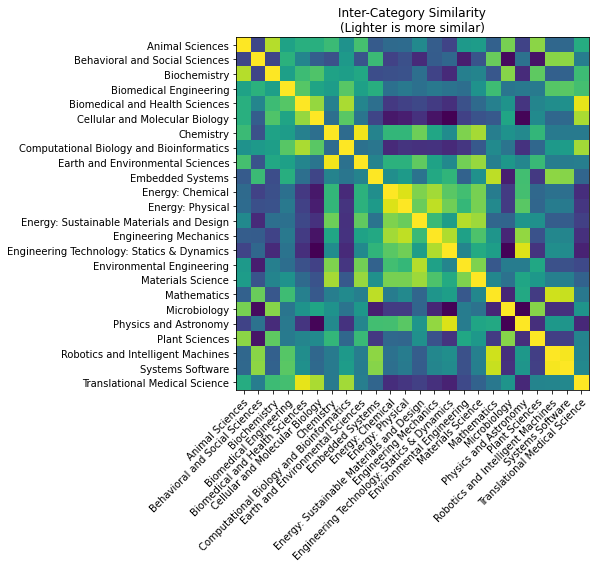

In [47]:
# distance between category centroids plotted as a grid comparision
array = []
for i, category in enumerate(categories):
    row = []
    for j, category in enumerate(categories):
        x_squared = (centroids_x[i] - centroids_x[j]) ** 2
        y_squared = (centroids_y[i] - centroids_y[j]) ** 2
        
        distance = (x_squared + y_squared) ** 0.5
        row.append(distance)
    array.append(row)

fig, ax = plt.subplots()
im = ax.imshow(-np.array(array))

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(categories)), labels=categories)
ax.set_yticks(np.arange(len(categories)), labels=categories)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_title("Inter-Category Similarity\n(Lighter is more similar)")
fig.tight_layout()
plt.savefig('category_similarity.png', transparent=False)
plt.show()

# Standard Deviation of Categories

Do all categories exhibit the same amout of variation from their `centroid` (`mean`) as others? 

A greater standard deviation would indicate that some categories host a wider variety of projects.

In [48]:
from scipy.spatial.distance import euclidean

def dist_from_category_mean(centroid, elem) -> float:
    """
    Gets the distance from the category mean
    """
    return ((centroid['x'] - elem[0]) ** 2 + (centroid['y'] - elem[1]) ** 2) ** 0.5

category_standard_dev = []
for i, category in enumerate(categories):
    category_embeddings = ds[ds['category'] == category]
    mean_dist = category_embeddings.apply(lambda x: dist_from_category_mean(x, [centroids_x[i], centroids_y[i]]), axis=1).mean()
    category_standard_dev.append(mean_dist)

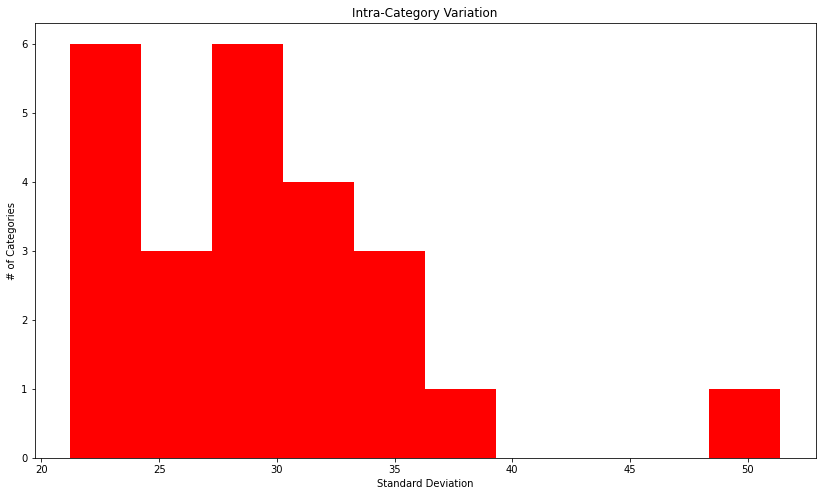

In [49]:
plt.hist(category_standard_dev)

plt.title("Intra-Category Variation")

plt.xlabel("Standard Deviation")
plt.ylabel("# of Categories")

plt.savefig("category_centroid_deviation.png", transparent=False)
plt.show()

In [50]:
list_of_categories = list(zip(categories, category_standard_dev))
list_of_categories = sorted(list_of_categories, key=lambda x: x[1], reverse=True)
cat_distances = pd.DataFrame(list_of_categories, columns=["Category", "Standard Deviation"])
cat_distances.round(2)

,Category,Standard Deviation
0,Mathematics,51.38
1,Chemistry,37.66
2,Materials Science,35.37
3,Energy: Chemical,35.14
4,Systems Software,34.45
5,Energy: Sustainable Materials and Design,31.66
6,Biomedical and Health Sciences,31.60
7,Biochemistry,30.41
8,Energy: Physical,30.35
9,Robotics and Intelligent Machines,30.27


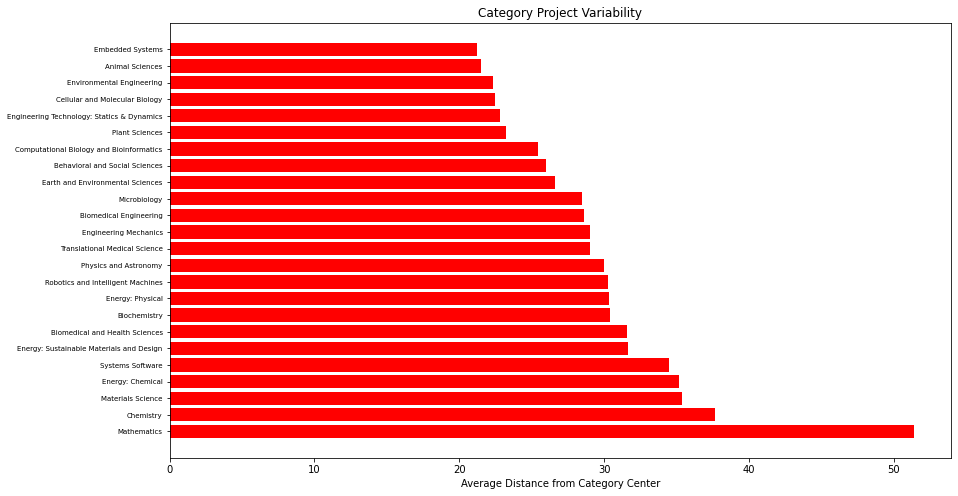

In [51]:
y_pos = np.arange(cat_distances['Category'].shape[0])

plt.barh(cat_distances['Category'], cat_distances['Standard Deviation'])

plt.yticks(y_pos, cat_distances['Category'], fontsize=7)

plt.xlabel('Average Distance from Category Center')
plt.title('Category Project Variability')

plt.savefig("cat_std.png", transparent=False)
plt.show()

# Category and Cluster Awards Analysis
Does the category a project is located in consitute a significant predictor of how well a project will do when analyzing the number of awards won?

Furthermore, are **synthetic clusters** of papers better predictors of awards won? If so, what are some of the characteristics of these projects?

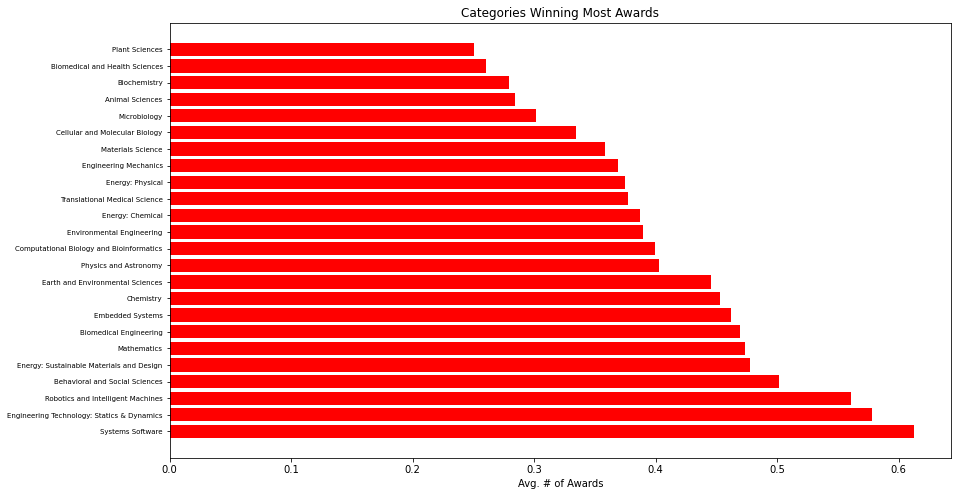

In [52]:
awards_by_category = ds.groupby('category')['num_awards'].mean().reset_index().sort_values('num_awards', ascending=False)

y_pos = np.arange(awards_by_category.shape[0])

plt.barh(awards_by_category['category'], awards_by_category['num_awards'])

plt.yticks(y_pos, awards_by_category['category'], fontsize=7)

plt.xlabel('Avg. # of Awards')
plt.title('Categories Winning Most Awards')

plt.savefig("awards_per_cat.png", transparent=False)
plt.show()

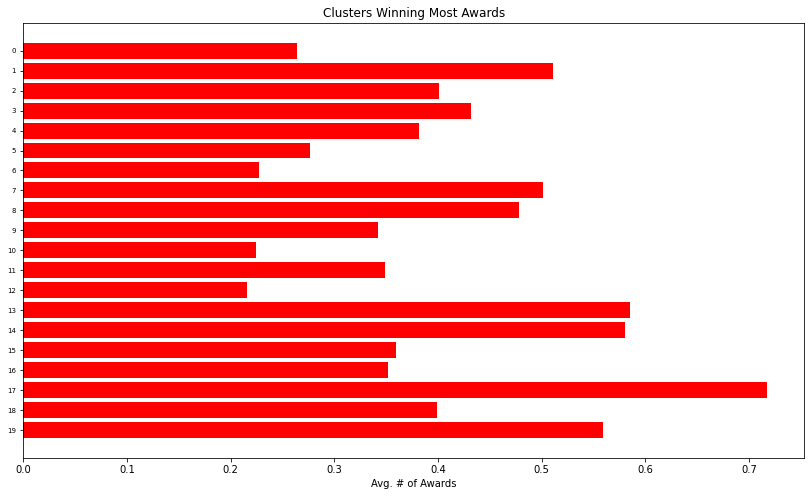

In [53]:
awards_by_cluster = ds.groupby('cluster')['num_awards'].mean().reset_index().sort_values('cluster', ascending=False)

y_pos = np.arange(awards_by_cluster.shape[0])

plt.barh(awards_by_cluster['cluster'], awards_by_cluster['num_awards'])

plt.yticks(y_pos, awards_by_cluster['cluster'], fontsize=7)

plt.xlabel('Avg. # of Awards')
plt.title('Clusters Winning Most Awards')

plt.savefig("awards_per_cat.png", transparent=False)
plt.show()

# Project "Uniquenesss" and the Effect on Awards Won

A project's "uniquness" can be represented by the distance from the **category** mean. Comparision to **category** mean, implies a relativeness to project interpretation. Project category implies a certain sphere or comparision and judges. Mean distance is a reflection of this point of comparision.

**Unique** is a strong term. While the metric is crude, distance should be a sufficient starting point for further examination of category-selection.

In [54]:
def dist_from_category_mean(centroid, elem) -> float:
    """
    Gets the distance from the category mean
    """
    return ((centroid['x'] - elem[0]) ** 2 + (centroid['y'] - elem[1]) ** 2) ** 0.5

def get_distance_from_center(x):
    try:
        i = categories.index(x['category'])
        c_x, c_y = centroids_x[i], centroids_y[i]
    
        return ((x['x'] - c_x) ** 2 + (x['y'] - c_y) ** 2) ** 0.5
    except:
        return None

ds['distance_from_center'] = ds.apply(get_distance_from_center, axis=1)

print(f"Mean Distance From Center: {ds['distance_from_center'].mean(): 0.1f}")
ds['distance_from_center'].to_frame() # frames display nicer

Mean Distance From Center:  29.7


,distance_from_center
0,19.976718
1,77.468596
2,78.619790
3,45.469267
4,63.148141
...,...
12264,20.360737
12265,20.865550
12266,29.674819
12267,20.230908


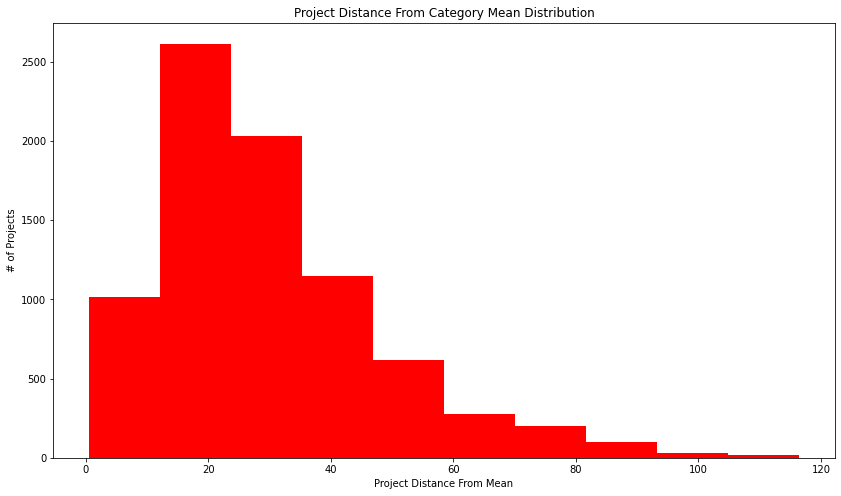

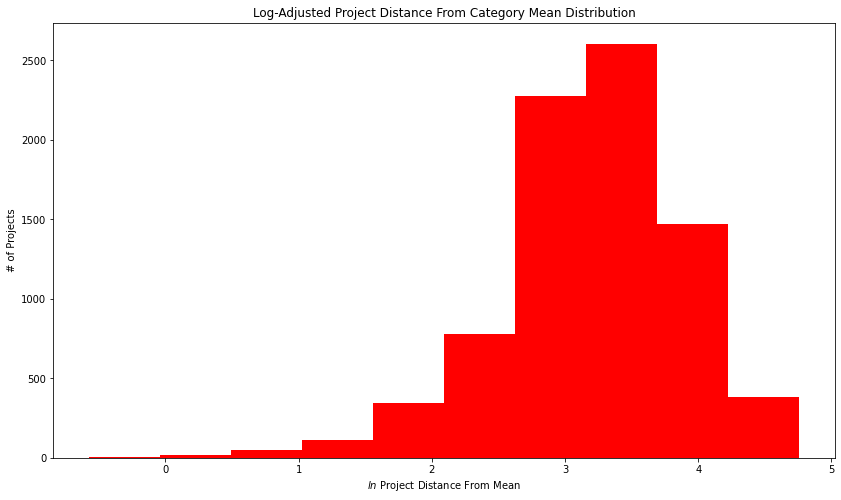

In [55]:
import math
plt.hist(ds['distance_from_center'])

plt.title("Project Distance From Category Mean Distribution")

plt.xlabel("Project Distance From Mean")
plt.ylabel("# of Projects")

plt.savefig("project_dist_from_category_mean.png", transparent=False)
plt.show()

### ---
plt.hist(ds['distance_from_center'].apply(math.log))

plt.title("Log-Adjusted Project Distance From Category Mean Distribution")

plt.xlabel("$ln$ Project Distance From Mean")
plt.ylabel("# of Projects")

plt.savefig("log_project_dist_from_category_mean.png", transparent=False)
plt.show()

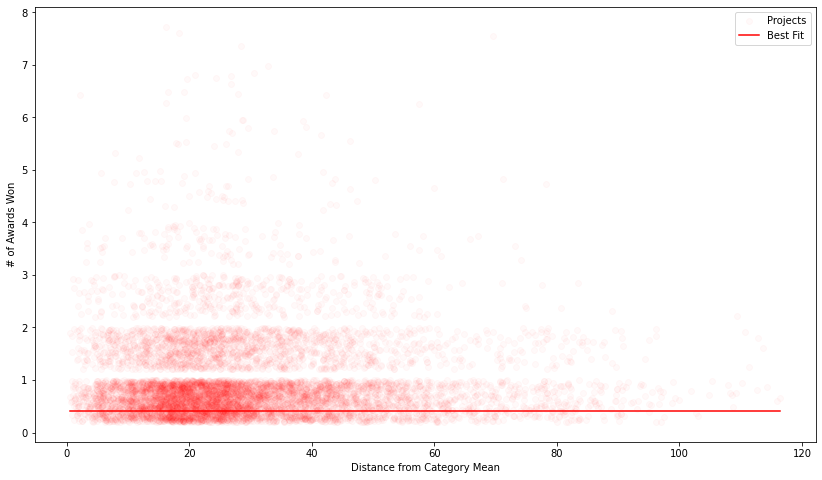

In [56]:
from sklearn.metrics import r2_score

degree = 2

awards_numpy = ds['num_awards'].to_numpy()
distance_from_center_numpy = ds['distance_from_center'].apply(lambda x: x ** 2).to_numpy()

idx = np.isfinite(awards_numpy) & np.isfinite(distance_from_center_numpy)

coefficients = np.polyfit(distance_from_center_numpy[idx], awards_numpy[idx], degree)

# Generate polynomial values for plotting
x_values = np.linspace(ds['distance_from_center'].min(), ds['distance_from_center'].max(), 100)
y_values = np.polyval(coefficients, x_values)

jittered_awards = ds['num_awards'] + np.random.uniform(0.2, size=ds['num_awards'].shape[0])
plt.scatter(ds['distance_from_center'], jittered_awards, label='Projects', alpha=0.025)
plt.plot(x_values, y_values, color='r', label='Best Fit')

plt.legend()
plt.ylabel("# of Awards Won")
plt.xlabel("Distance from Category Mean")

plt.savefig("awards_won_versus_distance_from_center.png", transparent=False)
plt.show()

# Extracting Keywords from Each Category

What is mentioned in each project is a key feature to understanding what is significant to each project. Grouping `ds` by both `category` and `cluster` will yield the more insights about the similarities and differences between these metrics.

This is done using Latent Dirichlet Allocation (LDA). More can be learned about LDA through [this](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) Wikipedia article. 

![LDA Overview](https://www.researchgate.net/profile/Diego-Buenano-Fernandez/publication/339368709/figure/fig1/AS:860489982689280@1582168207260/Schematic-of-LDA-algorithm.png)

In [57]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

NUM_TOPICS_PER_CLUSTER = 5

def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

def get_keywords_from_series(x):
    """
    Uses Latent Direct Asscoiation (LDA) to extract keywords from the `embeddings_input`
    
    Intended to be used with a groupby to extract keywords for `cluster` and `category`
    """
    documents = x.apply(lambda x: str(x['title']) + " " + str(x['abstract']), axis=1).to_list()
    vec = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
    vectorized_data = vec.fit_transform(documents)
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER,
                                    max_iter=10,
                                    learning_method='online',
                                   )
    lda.fit(vectorized_data)
    return selected_topics(lda, vec)
    
cluster_keywords = ds.groupby('cluster').progress_apply(get_keywords_from_series)
category_keywords = ds.groupby('category').progress_apply(get_keywords_from_series)

  0%|          | 0/20 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
100%|██████████| 24/24 [00:56<00:00,  2.36s/it]


In [58]:
from IPython.display import display, HTML
cluster_keywords.to_frame().to_csv('cluster_keywords.csv')
display(HTML(cluster_keywords.to_frame().to_html()))

,0
cluster,
0,"[robot, control, vehicle, using, design, algorithm, water, used, robots, project]"
1,"[cells, brain, neurons, cell, using, disease, effects, protein, alzheimer, flies]"
2,"[learning, model, using, neural, images, network, data, brain, eeg, wildfire, gender, california]"
3,"[solar, water, energy, temperature, using, cell, panel, electricity, power, led]"
4,"[drag, wing, design, wind, water, efficiency, model, temperature, sound, turbine, magnetic, using, different, field]"
5,"[quantum, number, using, data, theory, problem, numbers, algorithm, graphs, error, computers, model, algorithms]"
6,"[hand, people, impaired, device, data, using, patients, rehabilitation, parkinson, braille, music, printer]"
7,"[students, test, participants, stress, social, data, music, people, research, covid-, study, game, mask, experiment, muscle]"
8,"[cells, cell, gene, cancer, expression, immune, genes, mice, human, endothelial, angiogenesis, hypoxia]"


In [59]:
category_keywords.to_frame().to_csv('category_keywords.csv')

category_data = {
    "category": category_keywords.index,
    "keywords": category_keywords.apply(lambda x: ", ".join(x)).values
}

category_frame = pd.DataFrame(category_data)
display(HTML(category_frame.to_html()))

,category,keywords
0,Animal Sciences,"honey, eggs, bees, species, bee, larvae, control, effects, drosophila, rate, light, data, ants, food"
1,Behavioral and Social Sciences,"students, study, social, school, participants, emotional, using, research, people, music, race, gender, therapy, network, reading"
2,Biochemistry,"cells, protein, cell, using, samples, used, water, temperature, activity, light, concentration, concentrations, compounds, time, radiation"
3,Biomedical Engineering,"device, using, cancer, used, cells, cell, drug, tissue, light, glucose, blue"
4,Biomedical and Health Sciences,"cells, cancer, cell, study, data, patients, mice, results, used, using, effects, different, disease, inflammation"
5,Cellular and Molecular Biology,"cells, cell, cancer, protein, dna, using, editing, gene, neurons, age, resistance"
6,Chemistry,"water, using, nanoparticles, used, synthesis, students, reaction, compound, phosphorus, study, results, group, data"
7,Computational Biology and Bioinformatics,"model, data, using, genes, cells, cell, gene, binding, cancer, inhibitors, compounds, energy, docking, analysis"
8,Earth and Environmental Sciences,"water, data, using, model, used, algae, growth, ice, glacier, sand, sensor, speed, air"
9,Embedded Systems,"device, using, project, data, sensor, water, signal, car, encryption, algorithm, navigation"


From the **LDA** of each `category`, some things stood out namely, **cancer.**

Why is cancer talked about so much? As mentioned earlier, projects which mention cancer perform **no better than projects who do not**.

# Creating a Model to Predict How Many Awards Students Will Win

Using a basic **TensorFlow** model, the **number of awards won** will be calculated. 

Effective awards prediction would provide a **evaluation metric for improvment** upon which more sophisticated tools could be built. For instance, evaluating which category a project should enter is possible using a grid search based on **title** and **abstract**. 

Given the power of **TensorFlow JavaScript (TFJS)**, this model can be made available through an interactive website. 


> **Note:** I tried to make a awards predictor which only reached a mean-squared error of 0.75. Given a simple average reaching a baseline mean squared error of 0.9 on this dataset, the performance improvment observed did not represent a noteworthy accomplishment for this task
>
> Constructing a prediction model better than this baseline will be left as an exercise to the reader.

In [60]:
components = pca.components_

# Transform the eigenvalues into a diagonal matrix
eigenvalues = pca.explained_variance_
eigenvalue_matrix = np.diag(np.sqrt(eigenvalues))

# Express the PCA as a matrix
pca_linear_transform = np.dot(eigenvalue_matrix, components)

In [61]:
# Saving Everything
# Because the notebook takes a while to run, the data will be exported and then analyzed in a separate notebook and then combined back in one place

# The kaggle notebook has been lagging bad
import pickle
with open("pca.pickle", 'wb') as f:
    pickle.dump(pca_matrix, f)
    
with open("pca_matrix_linear_transform.pickle", "wb") as f:
    pickle.dump(pca_linear_transform, f)
    
ds.to_parquet("beforeML.parquet")

In [62]:
# Model definition


In [63]:
# Model Data Preparation


In [64]:
# Model Training 


In [65]:
# Model Evaluation

# Exporting Data to an Interactive Website

Using [Bokeh](https://bokeh.org), an interactive website will be created from the embeddings rendered. Highlighting dots will pull up information in a helpful tooltip about the project. 

Creating a tool for project and category **visualization** and **exploration** is the end goal of this project.

In [66]:
# Some categories were not in string format, messing things up
ds['category'] = ds['category'].apply(lambda x: str(x))
ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9618 entries, 0 to 12270
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   title                 9618 non-null   object 
 1   category              9618 non-null   object 
 2   year                  9618 non-null   int64  
 3   schools               9618 non-null   object 
 4   abstract              9618 non-null   object 
 5   id                    9618 non-null   int64  
 6   country               8624 non-null   object 
 7   State                 6375 non-null   object 
 8   Province              514 non-null    object 
 9   awards                8624 non-null   object 
 10  place                 9618 non-null   int64  
 11  num_awards            9618 non-null   int64  
 12  novel                 9618 non-null   bool   
 13  machine_learning      9618 non-null   bool   
 14  cancer                9618 non-null   bool   
 15  cheecky_titles      

In [67]:
from bokeh.models import ColumnDataSource

def awards_to_string(awards) -> str:
    """
    Converts the list of awards to a string
    """
    if not awards:
        return "" # nothing
    
    if awards == "nan":
        return ""
    
    if '[' in awards:
        awards = eval(awards)
    
    # lambda function filters out null strings
    return " | ".join(map(lambda x: str(x), filter(lambda x: x and 'nan' != x, awards)))


# NOTE: to_list() likely is redundant, but 10k items to too small to notice
source = ColumnDataSource(data={
    "x": ds['x'].to_list(),
    "y": ds['y'].to_list(),
    
    "x_back": ds['x'].to_list(),
    "y_back": ds['y'].to_list(),
    
    "year": ds["year"].to_list(),
    "title": ds["title"].to_list(),
    "category": ds["category"].to_list(),
    "awards": ds["awards"].apply(awards_to_string).to_list(),
    "url": ds["id"].apply(lambda id: f"https://abstracts.societyforscience.org/Home/FullAbstract?ProjectId={id}"),
    "num_awards": ds["num_awards"].to_list(),
    "abstract": ds["abstract"].to_list(),

#     "country": ds["country"].to_list(),
#     "schools": ds["schools"].apply(awards_to_string).to_list(),
})

In [68]:
from bokeh.models import HoverTool, WheelZoomTool, TapTool, OpenURL

hover = HoverTool(
    tooltips=[
        ("Title",   "@title"),
        ("Year",    "@year"),
        ("Category","@category"),
        ("Awards",  "@awards"),

#         ("Country", "@country"),
#         ("Schools", "@schools"),
#         ("Abstract","@abstract"),
    ]
)

# Create a TapTool and specify the action
tap_tool = TapTool(callback=OpenURL(url="@url"))

tools = [
    hover,
    'wheel_zoom',
    tap_tool,
]

In [69]:
from bokeh.models import CustomJS, Toggle, MultiChoice, TextInput
from bokeh.layouts import row

last_year = ds['year'].max()
last_year_data = ds[ds['year'] == last_year]['category'].unique().tolist() # NeoCategories

category_selector = MultiChoice(value=[], options=last_year_data, title="Filter by Category")
category_selector.js_on_change("value", CustomJS(args=dict(source=source), code="""
     const data = source.data;
    
    const category = data['category'];
    console.log(this.value);
    
    if(this.value.length === 0){
        for(let i = 0; i < category.length; i++){
            data['x'][i] = data['x_back'][i];
            data['y'][i] = data['y_back'][i];
        }
        return; // no category selected = all categories selected
    }
    
    for(let i = 0; i < category.length; i++){
        let include = false;
        for(let j = 0; j < this.value.length; j++){
            if(this.value[j] === category[i]){
                 include = true;
                 break;
            }
        }
        
        if(include){
            data['x'][i] = data['x_back'][i];
            data['y'][i] = data['y_back'][i];
        }else{
            data['x'][i] = undefined;
            data['y'][i] = undefined;
        }
    }
    source.change.emit();
"""))


winnging_projects_only = Toggle(label="Only Display Winning Projects?", button_type="success")
winnging_projects_only.js_on_change('active', CustomJS(args=dict(source=source), code="""
    const data = source.data;
    const numAwards = data['num_awards'];
    
    for(let i = 0; i < numAwards.length; i++){
        if(this.active && numAwards[i] > 0){
            data['x'][i] = undefined;
            data['y'][i] = undefined;
        }else{
            data['x'][i] = data['x_back'][i];
            data['y'][i] = data['y_back'][i];
        }
    }
    
    source.change.emit();
    console.log('toggle: active=' + this.active, this.toString())
"""))

search = TextInput(value="Search for projects", title="Search for Projects")
search.js_on_change("value", CustomJS(args=dict(source=source), code="""
    console.log('text_input: value=' + this.value, this.toString());
    
    const data = source.data;
    const title = data['title'];
    const abstract = data['abstract'];
    
    // str.includes
    let parts = this.value.toLowerCase().split(" "); // array of strings
    for(let i = 0; i < title.length; i++){
        if(typeof title[i] !== 'string'){
            continue; // aways include
        }
        let projectTitle = title[i].toLowerCase();
        let projectAbstract = abstract[i].toLowerCase();
        
        let quit = false;
        
        for(let j = 0; j < parts.length; j++){
            // checks the title
            const part = parts[j];

            if(projectTitle.includes(part) || projectAbstract.includes(part)){
                quit = true;
                break;
            }
        }
        
        if(quit){
            data['x'][i] = data['x_back'][i];
            data['y'][i] = data['y_back'][i];
        }else{    
            data['x'][i] = undefined;
            data['y'][i] = undefined;
        }
    }
    source.change.emit();
"""))

widgets = row(
    winnging_projects_only,
    search,
    category_selector
)

In [70]:
from bokeh.plotting import figure, output_notebook, show, curdoc
from bokeh.models import CategoricalColorMapper
from bokeh.palettes import Category20

category_mapper = CategoricalColorMapper(
    factors=ds['category'].apply(lambda x: str(x)).unique(),
    palette=Category20[20], # there will be some overlap ig
)

p = figure(
    title="Science Fair Projects Visualization",
    tools=tools,
    active_scroll ="wheel_zoom",
    width=900,
    height=700,
    output_backend="webgl", # 100x speedup
)

p.scatter(
    x="x",
    y="y",
    
    legend_field="category",
    color={'field': 'category', 'transform': category_mapper},
    
    alpha=0.4,
    size=7, # needs to be adjusted
    
    source=source,
)


# Examine Muting Lengends from:
# https://docs.bokeh.org/en/2.4.2/docs/user_guide/interaction/legends.html#muting-glyphs
# p.legend.click_policy="mute"
p.legend.label_text_font_size = "8px"

In [71]:
from bokeh.models.widgets import TableColumn, DataTable

# Creating the category data table
category_keywords = ColumnDataSource(category_frame)
category_columns = [
    TableColumn(field='category', title='Category'),
    TableColumn(field='keywords', title='Keywords'),
]

category_keywords_table = DataTable(
    source=category_keywords,
    columns=category_columns,
    width=900,
    height=700,
)

In [72]:
from bokeh.models import Panel, Tabs

# Creating tabs
plot_tab = Panel(child=p, title='t-SNE Visualization')
keywords_tab = Panel(child=category_keywords_table, title="Category Keywords")

main_tabs = Tabs(tabs=[plot_tab, keywords_tab])

In [73]:
from bokeh.models import Div
from bokeh.layouts import column

title = Div(text="<h1>International Science Fair Projects Analysis</h1>")

description = Div(text="""
Scraped data from the International Science and Engineering fair to identify relevant project trends at ISEF and generate insights about category selection.
<br>
The plot generated below is a 2D visualization of each projects. <strong>Closer points represents more similar projects</strong>. This association allows an intuitive visualization about the kinds and variety of projects present in each category.
""")

disclaimer = Div(text="""
All data presented comes from <a href="https://abstracts.societyforscience.org">abstracts.societyforscience.org</a>. <i>Society For Science</i> is not affilated with this project. To identify how this visulization was made, check out the <a href="https://www.kaggle.com/code/wkaisertexas/international-science-fair-analysis">Kaggle Notebook</a>
""")

layout = column(
    title,
    description,
    widgets,
    main_tabs,
    disclaimer,
)

In [74]:
from bokeh.io import output_file, save
from time import time

output_file("index.html", "ISEF Analysis | Top Science Fair Project Insights")

save(layout)

show(layout)

# Summary

In this notebook, a manual analysis of the `lore` surrounding the International Science and Engineering Fair took place. During the analysis, a bias toward: machine-learning, two-pronged titles, novel and platform-based projects.

The bias towards this category of projects is seemingly decreasing as the number of projects using these techniques is increasing. This is a good sign and reflective of a competitive flexability when evaluating projects, pushing the competition to evolve. 

Then, principle component analysis (PCA) was used in conjuction with t-SNE dimensionality reduction to plot OpenAI-generated embeddings of project titles and abstracts. The visualized embeddings revealed distinct clusters of papers related to categories. Furthermore, the relationships between cluster and category were also garnered. Weighting clusters by number of awards won yields directional movement. Directional movement suggests a qualitative difference between winning projects and the competition. 

The topics of each category were extracted using Latent Dirichlet Allocation (LDA), finding the common keywords for each cluster.

Creating a neural network to predict the number of awards won was attempted. However, this is not published due to limited internal sucess.

Finally, the project domain was visualized using Bokeh to create an interactive plot. 